## Analiza składowych głównych

### Generowanie danych

Chcemy stworzyć dwie serie danych: obie to wartości $\{-5, -4.9, -4.8, ..., 5\}$ z dodanym szumem $\xi$ pochodzącym z rozkładu jednorodnego $U ~ (-1/2, 1/2)$. Wykorzystujemy do tego pakiet **numpy**, który ma wygodną funkcję **arrange()** jak również cały zestaw funkcji do losowania, ukrytych pod **numpy.random**.

In [21]:
import numpy as np

x = np.arange(-5, 5, 0.1)

y = x + np.random.uniform(-0.5, 0.5, len(x))
x += np.random.uniform(-0.5, 0.5, len(x))

W większości przypadków wygodnie jest trzymać dane w **ramce danych (data frame)**, gdzie poszczególne kolumny mogą być różnych typów (oczywiście długość każdej kolumny musi być taka sama). Potrzebujemy do tego biblioteki **pandas** oraz pochodzącej z niej funkcji **DataFrame()**.

In [22]:
import pandas as pd

df = pd.DataFrame({'x':x, 'y':y})
df

,x,y
0,-4.852060,-4.732940
1,-4.439853,-5.345404
2,-4.325545,-5.062072
3,-4.570898,-5.086323
4,-4.786282,-4.995263
...,...,...
95,4.952283,4.321693
96,4.933899,4.598952
97,5.028653,5.088161
98,5.150190,4.973568


### Rysowanie

Rzecz jasna, ciężko zorientować się co do kształtu danych, patrząc się na ramkę :-) Dużo wygodniej jest wykonać wykres - my skorzystamy tu z biblioteki **seaborn**, która jest nastawiona na wizualizację danych zawartych w ramkach. Załadujemy jednak także bibliotekę **matplotlib**, bo niektóre rzeczy dodawane do rysunków bedziemy musieli osiągnać za jej pośrednictwem.

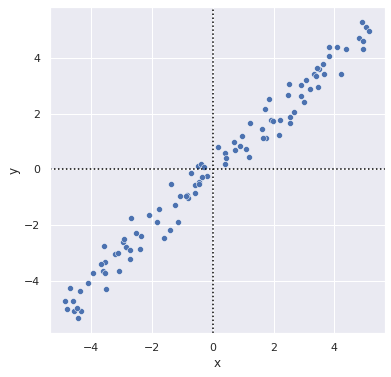

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.scatterplot(data = df, x = 'x', y = 'y')
g.axhline(0, color="black", linestyle=":")
g.axvline(0, color="black", linestyle=":")

### PCA "na piechotę"

Oczywiście powinniśmy wykorzystać gotowe oprogramowanie do wykonania PCA, ale jest to tak łatwa technika, ze warto sprawdzić, czy potafimy sobie z nią poradzić *step by step*, przy okazji przypominając sobie, jakie są jej założenia.

Pierwsza rzecz, która musimy wykonać, to policzyć macierz kowariancji.

In [24]:
s = np.cov(df, rowvar=False)
s

array([[8.66106712, 8.57543572],
       [8.57543572, 8.67632317]])

Kozrsytając z tej macierzy, możemy rozwiązać zagadnienie własne. Ponieważ funkcja **eig** nie sortuje wartości własnych (i opowiadających im wektorów), dobrze to zrobić ręcznie.

In [25]:
lam, u = np.linalg.eig(s.T)

idx = lam.argsort()[::-1]
lam = lam[idx]
u = u[:,idx]

In [26]:
lam

array([17.24413425,  0.09325604])

In [27]:
u

array([[-0.70679222, -0.7074212 ],
       [-0.7074212 ,  0.70679222]])

Mozemy teraz nanieść otrzymane dwa wektory na nasz rysunek, przy czym żeby wysunek był OK, musimy zadbać, aby skale były takie same.

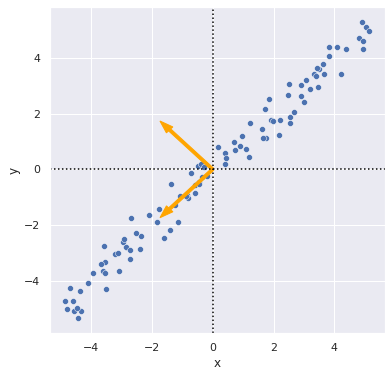

In [28]:
# Ustawienie rozmiaru rysunku
sns.set(rc={"figure.figsize":(6, 6)})

# Rysunek
g = sns.scatterplot(df, x = 'x', y = 'y')

# Zaznaczenie osi X i Y
g.axhline(0, color="black", linestyle=":")
g.axvline(0, color="black", linestyle=":")

# Dodanie dwóch wektorów
plt.arrow(0, 0, 2*u[0,0], 2*u[1,0], color = "orange", width = 0.1)
plt.arrow(0, 0, 2*u[0,1], 2*u[1,1], color = "orange", width = 0.1)

Zgodnie z naszym wykładem, nowe współrzędne powstają poprzez wykonanie mnożenia macierzowego $\mathbf{\Gamma}^{T} \mathbf{X}$, gdzie $\mathbf{\Gamma}$ to macierz wektorów własnych, a $\mathbf{X}$ to macierz naszych danych.

In [29]:
df1 = df @ u
df1.columns = ['x1', 'y1']

df1

,x1,y1
0,6.777581,0.087245
1,6.919506,-0.637244
2,6.638279,-0.517851
3,6.828848,-0.361423
4,6.916661,-0.144695
...,...,...
95,-6.557493,-0.448811
96,-6.740637,-0.239841
97,-7.153686,0.038897
98,-7.158522,-0.128074


Możemy też wykreślić te dane w nowym układzie współrzędnych.

(-6.0, 6.0)

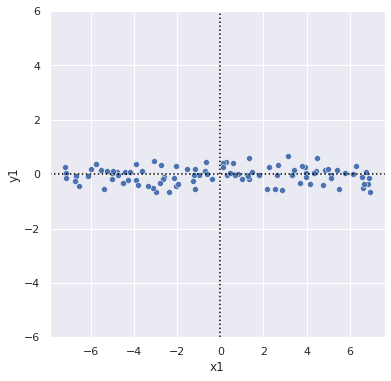

In [30]:
g = sns.scatterplot(df1, x = 'x1', y = 'y1', )
g.axhline(0, color="black", linestyle=":")
g.axvline(0, color="black", linestyle=":")
plt.ylim(-6, 6)

Wyraźnie widać, że nowa składowa $x_1$ ma dużą wariancję, podczas gdy $y_1$ - minimalną. Warto to oczywiście policzyć:

x1    17.071693
y1     0.092323
dtype: float64


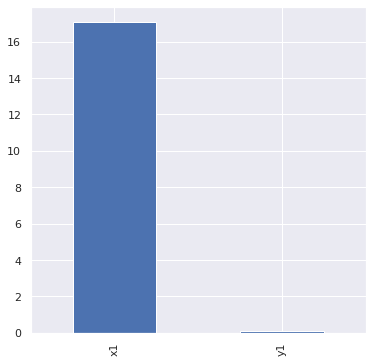

In [31]:
v = np.var(df1)
print(v)
v.plot.bar();

### PCA za pomocą pakietu scikit

In [32]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df)

PCA()

Zacznijmy od tego, od czego skończyliśmy, czyli od wariancji, która możemy pokazać albo jako wartości, albo też jako wartości skumulowane (co jest wygodne w przypadku wybierania wymiarów do "odcięcia".

In [33]:
pca.explained_variance_

array([17.24413425,  0.09325604])

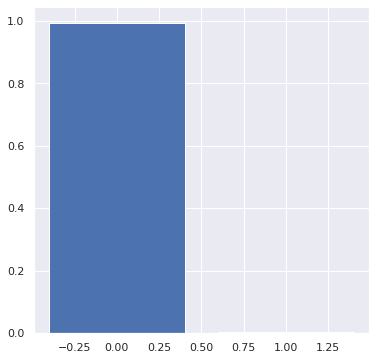

In [34]:
plt.bar(range(2), pca.explained_variance_ratio_);

In [35]:
pca.components_

array([[ 0.70679222,  0.7074212 ],
       [-0.7074212 ,  0.70679222]])

In [36]:
pd.DataFrame(pca.fit_transform(df))

,0,1
0,-6.738208,0.124399
1,-6.880134,-0.600090
2,-6.598906,-0.480696
3,-6.789475,-0.324269
4,-6.877289,-0.107541
...,...,...
95,6.596865,-0.411657
96,6.780009,-0.202687
97,7.193058,0.076052
98,7.197894,-0.090920


Czemu nie zgadza się to z wcześniej policzonymi wartościami? Otoż powinniśmy wycentrować jeszcze zbiór danych, tzn. odjąć wartości oczekiwane, a dopiero później mnożyć przez wektory własne, czyli $\mathbf{Y}=\mathbf{\Gamma}^{T}(\mathbf{X} - \mathbf{m})$

In [60]:
m = np.mean(df, axis = 0)
df1 = (df - m) @ u
df1.columns = ['x1', 'y1']

df1

,x1,y1
0,6.738208,0.124399
1,6.880134,-0.600090
2,6.598906,-0.480696
3,6.789475,-0.324269
4,6.877289,-0.107541
...,...,...
95,-6.596865,-0.411657
96,-6.780009,-0.202687
97,-7.193058,0.076052
98,-7.197894,-0.090920


## Liniowa analiza dyskryminacyjna (LDA)

Konstruujemy zestaw danych pochodzących z wielowmyiarowego rozkładu Gaussa.

In [187]:
mu1 = np.array([0, 0])
sd1 = np.array([[1, 0], [0, 1]])
n1, n2 =  30, 20

data1 = np.random.multivariate_normal(mu1, sd1, n1)
data2 = np.random.multivariate_normal(mu1 + 2, sd1, n2)

data = np.concatenate((data1, data2), axis = 0)
data = pd.DataFrame(data, columns=["x", "y"])

data["cl"] = np.repeat([0, 1], [n1, n2])

In [63]:
data

,x,y,cl
0,0.012147,-0.016900,0
1,1.984526,0.905724,0
2,-0.650948,-1.900095,0
3,-1.978879,0.404726,0
4,-1.417974,-0.639722,0
...,...,...,...
145,3.418512,1.080042,1
146,2.816882,2.332684,1
147,2.596071,2.317476,1
148,2.148565,3.088436,1


Poniższy rysunek przedstawia wylosowane dane wraz z nałożonymi gęstościami prawdopodobieństwa.

<AxesSubplot: xlabel='x', ylabel='y'>

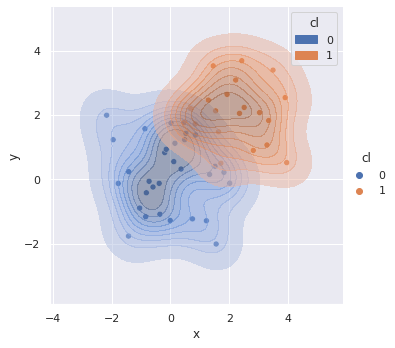

In [188]:
sns.relplot(data, x = 'x', y = 'y', hue = "cl")
sns.kdeplot(data, x = 'x', y = 'y', hue = "cl", fill = True, alpha = 0.5)

Ładujemy klasyfikatory z biblioteki sklearn:

In [65]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [66]:
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

In [67]:
lda.fit(data[["x", "y"]], data["cl"])
qda.fit(data[["x", "y"]], data["cl"])

QuadraticDiscriminantAnalysis()

Będą nam również potrzebne narzędzia z grupy metryk: macierz pomyłek i raporty

In [68]:
from sklearn.metrics import *

In [69]:
confusion_matrix(data["cl"], lda.predict(data[["x", "y"]]))

array([[93,  7],
       [ 3, 47]])

In [70]:
print(classification_report(data["cl"], lda.predict(data[["x", "y"]])))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       100
           1       0.87      0.94      0.90        50

    accuracy                           0.93       150
   macro avg       0.92      0.94      0.93       150
weighted avg       0.94      0.93      0.93       150



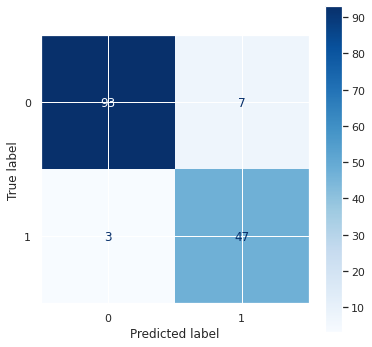

In [71]:
ConfusionMatrixDisplay.from_estimator(lda, data[["x","y"]], data["cl"], cmap=plt.cm.Blues)

Oprócz samej klasyfikacji możemy również po prostu otrzymać prawddopodobieństwo a posteriori przynależności do danej klasy $p(klasa|\mathbf{x})$ - wartości te sumują się do 1.

In [72]:
lda.predict_proba(data[["x","y"]])

array([[9.90484239e-01, 9.51576066e-03],
       [2.45610642e-01, 7.54389358e-01],
       [9.99829409e-01, 1.70590668e-04],
       [9.99828014e-01, 1.71986466e-04],
       [9.99844027e-01, 1.55973093e-04],
       [9.59652796e-01, 4.03472043e-02],
       [5.70426209e-01, 4.29573791e-01],
       [1.16534558e-01, 8.83465442e-01],
       [9.99693122e-01, 3.06877554e-04],
       [9.98440720e-01, 1.55928030e-03],
       [9.96001300e-01, 3.99870027e-03],
       [9.99415527e-01, 5.84472646e-04],
       [1.36433463e-01, 8.63566537e-01],
       [9.93642618e-01, 6.35738162e-03],
       [9.89535871e-01, 1.04641291e-02],
       [9.98007274e-01, 1.99272647e-03],
       [8.92430674e-01, 1.07569326e-01],
       [9.77496055e-01, 2.25039454e-02],
       [9.99372116e-01, 6.27883853e-04],
       [9.99944448e-01, 5.55518670e-05],
       [9.93511340e-01, 6.48866001e-03],
       [9.97291278e-01, 2.70872181e-03],
       [9.98388562e-01, 1.61143776e-03],
       [9.99192559e-01, 8.07440933e-04],
       [9.126377

Możemy też wykreślić linię (ogólnie hiperpłaszczyznę) rodzielającą klasy. W tym celu musimy po prostu w każdym punkcie policzyć prawdopodobieństwo przynależności do klasy, a następnie zaznaczyć warstwicę dla której do prawdopodobieństwo jest równe $1/2$. Korzystamy z funkcji **meshgrid()** tworzącej siatkę ze wszystkimi wartościami współprzędnych x i y, następnie dokonujemy przewidywania, a na końcu zamieniamy tę siatkę na macierz i ją przekazujemy do funkcji **contour()**.

In [73]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))

In [78]:
Zlda = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Zqda = qda.predict_proba(np.c_[xx.ravel(), yy.ravel()])

/home/julas/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/home/julas/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(


In [79]:
Zlda = Zlda[:, 1].reshape(xx.shape)
Zqda = Zqda[:, 1].reshape(xx.shape)

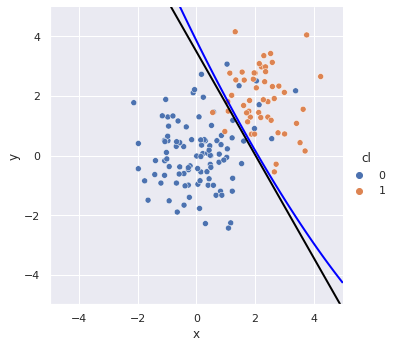

In [110]:
sns.relplot(data, x = 'x', y = 'y', hue = "cl")
#sns.kdeplot(data, x = 'x', y = 'y', hue = "class", fill = True, alpha = 0.5)

plt.contour(xx, yy, Zlda, [0.5], linewidths=2.0, colors="black")
plt.contour(xx, yy, Zqda, [0.5], linewidths=2.0, colors="blue");

Łatwiejszą opcją jest użycie funkcji **DecisionBoundaryDisplay()** - zrobi ona to za nas sama, bez żmudnych przekształceń danych.

In [83]:
from sklearn.inspection import DecisionBoundaryDisplay

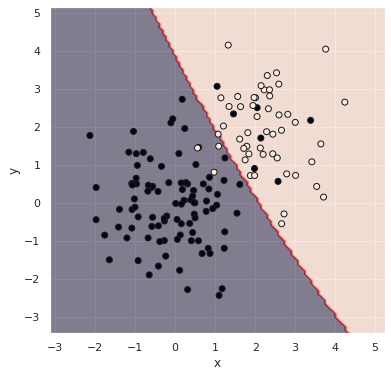

In [84]:
disp = DecisionBoundaryDisplay.from_estimator(qda, data[["x","y"]], response_method="predict", alpha=0.5)
disp.ax_.scatter(data.x, data.y, c=data.cl, edgecolor="k")

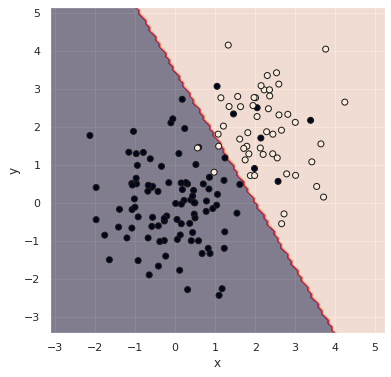

In [85]:
disp = DecisionBoundaryDisplay.from_estimator(lda, data[["x","y"]], response_method="predict", alpha=0.5)
disp.ax_.scatter(data.x, data.y, c=data.cl, edgecolor="k")

Możemy teraz sprawdzić, czy w przypadku LDA granica zgadza się z wyliczoną ręcznie: potrzebne nam są teraz wartości oczekiwane $m_1$ i $m_2$ oraz średnia ważona macierz kowariancji $\mathbf{S}$

In [86]:
S1 = np.cov(data[data["cl"] == 0][["x","y"]].T)
S2 = np.cov(data[data["cl"] == 1][["x","y"]].T)

S = ((n1 - 1) * S1 + (n2 - 1) *S2)/(n1 + n2 - 2)

m = data.groupby("cl").mean()
m1 = m.iloc[0,:]
m2 = m.iloc[1,:]

Mając już to obliczone, możemy się posłużyć wzorem ze [Slajdu 12 na Wykładzie 9](https://jsienkiewicz.pl/WDS/pliki/WDS09.pdf) tzn 

$\ln \frac{\pi_1}{\pi_2} - \frac{1}{2} (\mathbf{m}_1-\mathbf{m}_2)^{T} \mathbf{S}^{-1} (\mathbf{m}_1+ \mathbf{m}_2) + (\mathbf{m}_1-\mathbf{m}_2)^{T} \mathbf{S}^{-1} \mathbf{x} = 0$

Jest równanie prostej 

$a_x x + a_y y + b = 0$

tzn

$y = -\frac{a_x}{a_y} x - \frac{b}{a_y} = A x + B$


gdzie $\mathbf{a}$ oraz $b$ są równe:

$\mathbf{a}^{T} = (\mathbf{m}_1-\mathbf{m}_2)^{T} \mathbf{S}^{-1}$

$b = \ln \frac{\pi_1}{\pi_2} - \frac{1}{2}\mathbf{a}^{T}(\mathbf{m}_1 + \mathbf{m}_2)$

In [99]:
m = data.groupby("cl").mean()
m1 = m.iloc[0,:]
m2 = m.iloc[1,:]

a = (m1 - m2).T @ np.linalg.inv(S)
b = np.log(n1/ n2) - 0.5 * a.T @ (m1 + m2)

B = -b / a[1]
A = -a[0] / a[1]

print(A,B)

-1.7310331894696076 3.4971797235964526


Teraz możemy użyć funkcji **axline()** podając wyraz wolny i współczynnik kierunkowy.

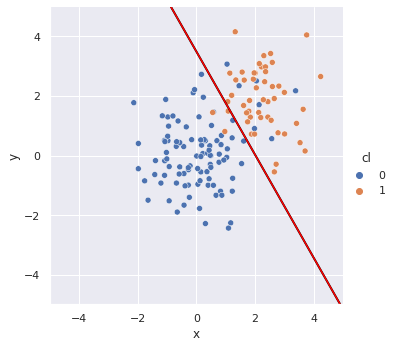

In [104]:
g = sns.relplot(data, x = 'x', y = 'y', hue = "cl")
#sns.kdeplot(data, x = 'x', y = 'y', hue = "class", fill = True, alpha = 0.5)

plt.contour(xx, yy, Zlda, [0.5], linewidths=2.0, colors="black")
plt.axline((0,B), slope = A, color="red");

## Analiza zbioru irysów

To chyba jeden z najpopularniejszych *gold standards*, na którym testuje się często metody ML.

In [111]:
iris = sns.load_dataset("iris")

iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


Aby przekonać się, jak wygląda zbiór robimy scatterplot dla każdej pary zmiennych:

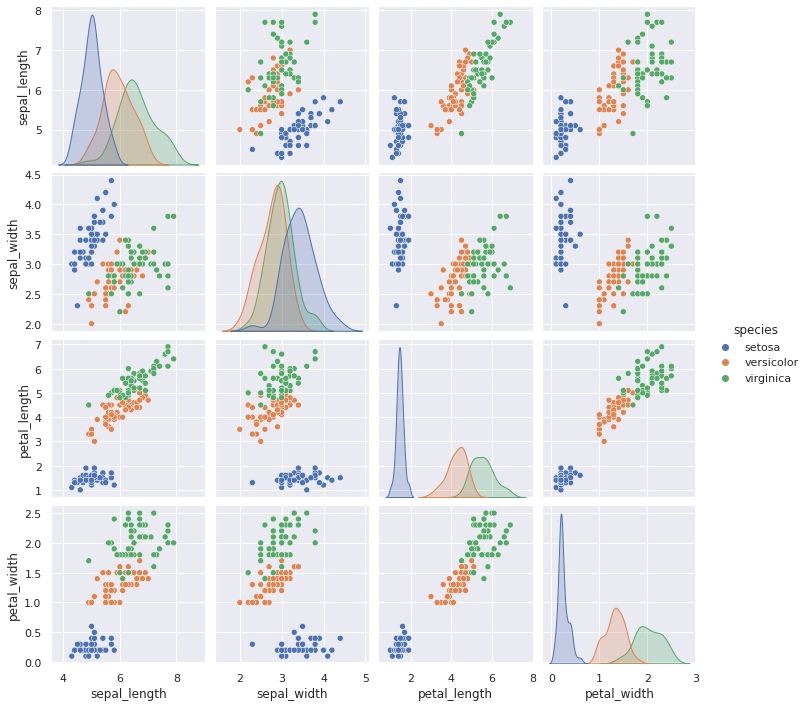

In [112]:
sns.pairplot(iris, hue="species");

Cały zbiór irysów daje dość dobre wyniki przy użyciu metody LDA

In [113]:
lda_iris = LinearDiscriminantAnalysis()

In [114]:
X = iris.drop("species", axis = 1)
y = iris["species"]

lda_iris.fit(X, y)

LinearDiscriminantAnalysis()

In [115]:
print(classification_report(y, lda_iris.predict(X)))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       0.98      0.96      0.97        50
   virginica       0.96      0.98      0.97        50

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



In [116]:
confusion_matrix(y, lda_iris.predict(X))

array([[50,  0,  0],
       [ 0, 48,  2],
       [ 0,  1, 49]])

Jeśli jednak wykorzystamy tylko dwie pierwsze składowe, to otrzymamy znaczny spadek statystyk.

In [117]:
lda_iris.fit(X.iloc[:,0:2], y)

LinearDiscriminantAnalysis()

In [118]:
confusion_matrix(y, lda_iris.predict(X.iloc[:,0:2]))

array([[49,  1,  0],
       [ 0, 36, 14],
       [ 0, 15, 35]])

Po zastosowaniu PCA efekt jest dużo lepszy.

In [119]:
pca_iris = PCA()
pca_iris.fit(X)

PCA()

In [120]:
x = pca_iris.transform(X)
iris_pca = pd.DataFrame(x, columns = ["x1", "x2", "x3", "x4"])
iris_pca["species"] = y

In [121]:
pca_iris.components_

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102],
       [-0.58202985,  0.59791083,  0.07623608,  0.54583143],
       [-0.31548719,  0.3197231 ,  0.47983899, -0.75365743]])

<BarContainer object of 4 artists>

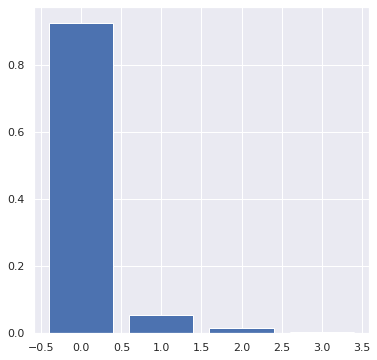

In [122]:
plt.bar(range(4), pca_iris.explained_variance_ratio_)

In [123]:
lda_iris = LinearDiscriminantAnalysis()
lda_iris.fit(iris_pca[["x1","x2"]], y)

LinearDiscriminantAnalysis()

In [124]:
confusion_matrix(y, lda_iris.predict(iris_pca[["x1","x2"]]))

array([[50,  0,  0],
       [ 0, 48,  2],
       [ 0,  4, 46]])

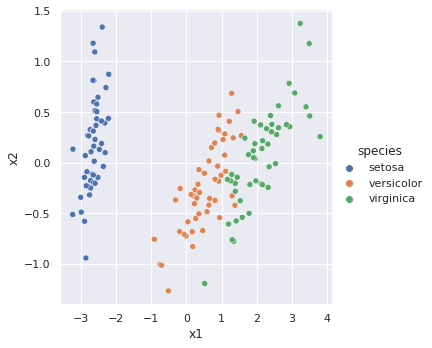

In [125]:
sns.relplot(iris_pca[["x1", "x2", "species"]], x = "x1", y = "x2", hue = "species")

## Klastrowanie

In [189]:
from sklearn.cluster import KMeans
X = data.drop("cl", axis = 1)

In [192]:
km = KMeans(n_clusters = 3).fit(X)

In [193]:
confusion_matrix(data["cl"], km.labels_)

array([[15,  0, 15],
       [ 0, 15,  5],
       [ 0,  0,  0]])

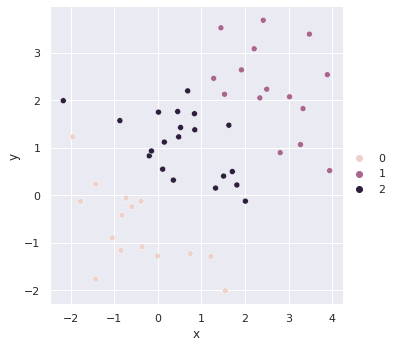

In [194]:
sns.relplot(data, x = 'x', y = 'y', hue = km.labels_)

In [166]:
sse = [KMeans(n_clusters = k).fit(X).inertia_ for k in range(1,10)]

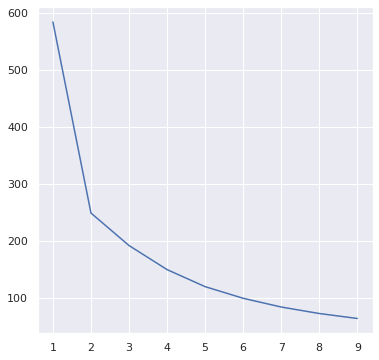

In [167]:
plt.plot(range(1, 10), sse)

In [168]:
from sklearn.cluster import AgglomerativeClustering

In [224]:
acs = AgglomerativeClustering(n_clusters=4).fit(X)

In [225]:
acs.labels_

array([0, 3, 3, 0, 3, 2, 0, 2, 2, 0, 0, 2, 0, 0, 3, 2, 0, 0, 3, 2, 0, 0,
       3, 3, 2, 3, 3, 0, 3, 3, 1, 2, 0, 0, 1, 1, 1, 0, 0, 1, 2, 1, 2, 1,
       0, 2, 1, 1, 1, 0])

In [174]:
from scipy.cluster import hierarchy

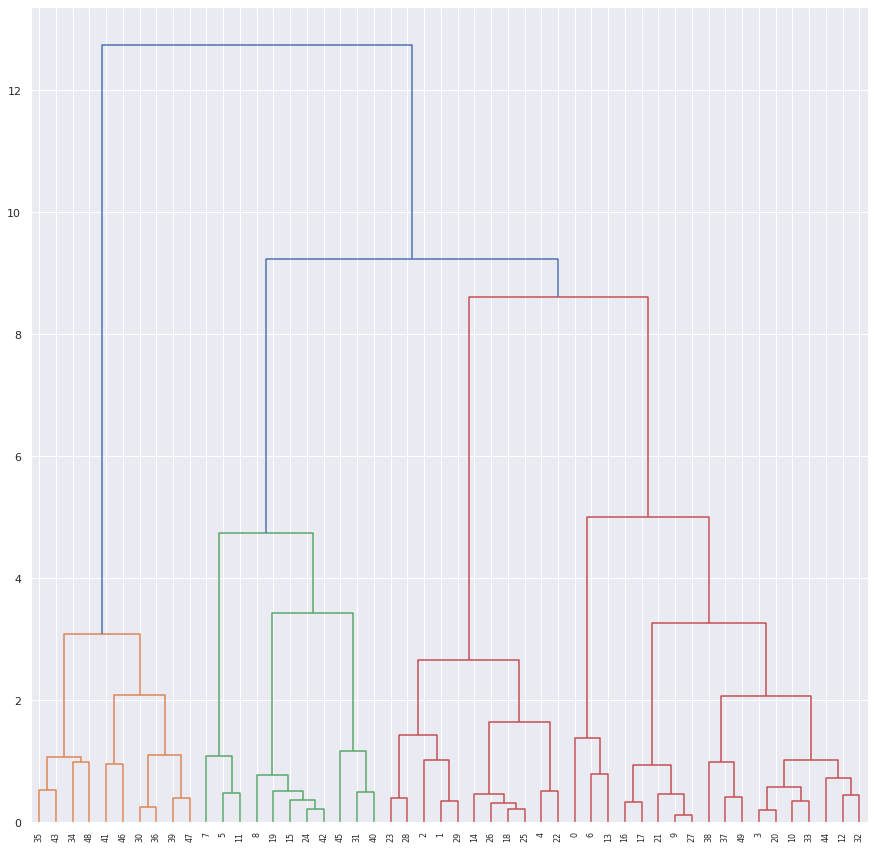

In [244]:
sns.set(rc={"figure.figsize":(15, 15)})
dn = hierarchy.dendrogram(hierarchy.linkage(X, "ward"))

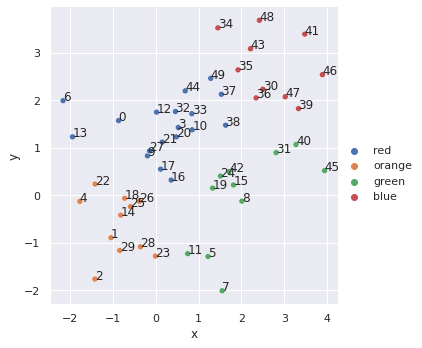

In [245]:

g = sns.relplot(data, x = 'x', y = 'y', hue = np.array(["red", "blue", "green", "orange"])[acs.labels_])

for i in range(50):
    plt.text(x = data["x"][i], y = data["y"][i], s = i)